In [22]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays

using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [4]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= 0.07; k2 = 0.07
k = 0.0
tspan = (0.0, 300000.0)

(0.0, 300000.0)

In [25]:
k_space = range(0.0, 1.0, step = 0.0004)


spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)
length(k_space)

2501

In [26]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
  0.07
  0.07
  0.0

In [27]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, k]
    println("p: $p"); flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
index: 1
k: 0.0
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0]
Spectrum: [0.014736564776395742, 0.007405390385949137, 0.0001343891589516976, -0.0016323158426994006, -7.133427733817622, -10.183865552493277]
Last point: [-1.262547616311424, -7.111367836284166, 3.6704824121018835, -1.002035197498644, -4.245278790420553, 3.747735025647847]
x_sum before truncate length: 3680739
x_sum after truncate length: 1840371
counts: 189
>>>>>>>>>>>>>>>

Initial condition: [-1.262547616311424, -7.111367836284166, 3.6704824121018835, -1.002035197498644, -4.245278790420553, 3.747735025647847]
index: 2
k: 0.0004
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0004]
Spectrum: [0.014946195295932128, 0.007389330021943392, 2.4456738524635134e-5, -0.002038499407149041, -7.1246185069234835, -10.194582489945631]
Last point: [0.3477290220880707, 0.6303048786467218, 4.070467544886714, -1.1667512296205538, -5.922232739836087, 

Last point: [-0.9718359081111765, -4.225055214406575, 3.475428399498312, -0.6180942070643124, -1.4530708465507178, 3.825029328046777]
x_sum before truncate length: 3690704
x_sum after truncate length: 1845353
counts: 109
>>>>>>>>>>>>>>>

Initial condition: [-0.9718359081111765, -4.225055214406575, 3.475428399498312, -0.6180942070643124, -1.4530708465507178, 3.825029328046777]
index: 15
k: 0.0056
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0056]
Spectrum: [0.015514126081620347, 0.007865344243478506, 2.2235403548205546e-5, -0.0016590308552369897, -7.115089372160353, -10.223451211339272]
Last point: [-0.7921514475118745, -2.3041114377514433, 4.050438215466497, -0.941613124452568, -3.373519767790204, 4.129155503419791]
x_sum before truncate length: 3685430
x_sum after truncate length: 1842716
counts: 103
>>>>>>>>>>>>>>>

Initial condition: [-0.7921514475118745, -2.3041114377514433, 4.050438215466497, -0.941613124452568, -3.373519767790204, 4.129155503419791]
index: 16


index: 28
k: 0.0108
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0108]
Spectrum: [0.016866948136144363, 0.008936986571836041, 0.00021377090576962224, -0.0010301168762515483, -7.091357803157036, -10.227065652306107]
Last point: [-0.9600878831077859, -3.9652315983344852, 3.6437587285885433, -0.9539875999298704, -4.03759782311663, 3.5042662747616244]
x_sum before truncate length: 3686634
x_sum after truncate length: 1843318
counts: 84
>>>>>>>>>>>>>>>

Initial condition: [-0.9600878831077859, -3.9652315983344852, 3.6437587285885433, -0.9539875999298704, -4.03759782311663, 3.5042662747616244]
index: 29
k: 0.0112
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0112]
Spectrum: [0.016638901314777726, 0.008979912538463376, 0.0003573212486799487, -0.000810701070992745, -7.091050189672475, -10.235494683642607]
Last point: [-0.739625111222469, -2.093581440660297, 3.89024480359511, -1.271399821525881, -6.90844748294769, 4.0157894887047085]
x_sum before truncate 

Last point: [1.4345720255665337, -1.555254485081071, 4.132810056484347, 0.0832426070631336, 0.47617619343851697, 4.040409250294933]
x_sum before truncate length: 3681872
x_sum after truncate length: 1840937
counts: 74
>>>>>>>>>>>>>>>

Initial condition: [1.4345720255665337, -1.555254485081071, 4.132810056484347, 0.0832426070631336, 0.47617619343851697, 4.040409250294933]
index: 42
k: 0.0164
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0164]
Spectrum: [0.017488271427618933, 0.009168230347950276, 0.00025711299171154756, -0.0005569863698000792, -7.062365892684156, -10.263794199545465]
Last point: [-0.8157385535129114, -2.9160825762632965, 3.5347236516489806, -1.210046098053816, -6.536933042311954, 3.614833819680114]
x_sum before truncate length: 3687025
x_sum after truncate length: 1843514
counts: 112
>>>>>>>>>>>>>>>

Initial condition: [-0.8157385535129114, -2.9160825762632965, 3.5347236516489806, -1.210046098053816, -6.536933042311954, 3.614833819680114]
index: 43
k:

index: 55
k: 0.0216
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0216]
Spectrum: [0.01796653299248686, 0.009957353345646248, 0.000804680862640653, -0.00017374138136010922, -7.038754471544729, -10.291260238310565]
Last point: [-0.9310385445687568, -3.2797998412422977, 4.133283366725325, -0.9475126117484775, -3.470246843877976, 4.075685507338392]
x_sum before truncate length: 3688739
x_sum after truncate length: 1844371
counts: 88
>>>>>>>>>>>>>>>

Initial condition: [-0.9310385445687568, -3.2797998412422977, 4.133283366725325, -0.9475126117484775, -3.470246843877976, 4.075685507338392]
index: 56
k: 0.022
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.022]
Spectrum: [0.018306004135339542, 0.00944586212076702, 0.0006122330696709183, -0.0005546879913672844, -7.037250522405052, -10.29421007130776]
Last point: [-0.8692109444882248, -2.888493934816675, 4.014300854382318, -1.1268288292431328, -5.190418303098888, 4.069099090576094]
x_sum before truncate leng

x_sum before truncate length: 3703117
x_sum after truncate length: 1851560
counts: 92
>>>>>>>>>>>>>>>

Initial condition: [-0.8244882768402214, -3.3897741329858886, 4.071899291625989, -0.917098534998394, -3.2285468066547502, 4.094393889909029]
index: 69
k: 0.0272
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0272]
Spectrum: [0.01839341648056241, 0.00982666954588839, 0.0006688351425307671, -0.000306980407240628, -7.018576952168745, -10.325822789097394]
Last point: [-0.882356981042286, -3.1048610849933502, 3.885458164556656, -1.0610389493163839, -4.740061630782852, 3.8247309837540135]
x_sum before truncate length: 3713426
x_sum after truncate length: 1856714
counts: 104
>>>>>>>>>>>>>>>

Initial condition: [-0.882356981042286, -3.1048610849933502, 3.885458164556656, -1.0610389493163839, -4.740061630782852, 3.8247309837540135]
index: 70
k: 0.0276
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0276]
Spectrum: [0.018498054104533722, 0.00966224825235772, 0

k: 0.0324
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0324]
Spectrum: [0.018448311622662705, 0.00961399276861196, 0.0003800956672759775, -0.0008514875832168798, -7.020478404945085, -10.357303694253394]
Last point: [-1.3988623884673195, -8.885352939891444, 3.7397703840155936, -0.6775438783790131, -1.8689823629730808, 3.6981797019372267]
x_sum before truncate length: 3725511
x_sum after truncate length: 1862757
counts: 25
>>>>>>>>>>>>>>>

Initial condition: [-1.3988623884673195, -8.885352939891444, 3.7397703840155936, -0.6775438783790131, -1.8689823629730808, 3.6981797019372267]
index: 83
k: 0.0328
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0328]
Spectrum: [0.018609666442589375, 0.009158695183503306, 0.0001437636983863047, -0.0008536762070189553, -7.007136873607973, -10.375773145354954]
Last point: [-1.128990240503325, -5.721585775486795, 3.5347263963314557, -0.5613127848966442, -1.081805395386961, 3.9163687855644382]
x_sum before truncate lengt

x_sum before truncate length: 3737191
x_sum after truncate length: 1868597
counts: 2
>>>>>>>>>>>>>>>

Initial condition: [-0.9424129163584845, -4.113700992428966, 3.527604417308968, 0.013165871722520796, 0.5215380191733483, 4.021709110579043]
index: 96
k: 0.038
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.038]
Spectrum: [0.018645006117105876, 0.008684165738481237, 5.084411591680414e-5, -0.001575371907805061, -7.054826727106507, -10.368894739802293]
Last point: [-0.8113980458007476, -2.484039672094902, 4.279613590338572, 1.6167359564516397, -2.5824669128375444, 3.874974452772795]
x_sum before truncate length: 3734189
x_sum after truncate length: 1867096
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8113980458007476, -2.484039672094902, 4.279613590338572, 1.6167359564516397, -2.5824669128375444, 3.874974452772795]
index: 97
k: 0.0384
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0384]
Spectrum: [0.018426350766318052, 0.008827323787908068, 1.1025

Spectrum: [0.018002582932740655, 0.0076819065877443285, 1.3606650476918633e-5, -0.0036365256839628194, -7.049066845763495, -10.440173176246606]
Last point: [-1.2913289775065147, -7.127618571477571, 4.0614785803402365, -0.8722806809232401, -2.765808881714086, 4.166894104865741]
x_sum before truncate length: 3772522
x_sum after truncate length: 1886262
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.2913289775065147, -7.127618571477571, 4.0614785803402365, -0.8722806809232401, -2.765808881714086, 4.166894104865741]
index: 110
k: 0.0436
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0436]
Spectrum: [0.017980194882198815, 0.008328875463414731, 1.2099935078872059e-5, -0.003655268293766613, -7.0409582261911305, -10.446395605993773]
Last point: [1.59196499926073, -2.0542328327197183, 3.6426278456559986, -0.8318824906000277, -2.8387431655411577, 4.054807446934212]
x_sum before truncate length: 3769102
x_sum after truncate length: 1884552
counts: 0
>>>>>>>>>>>>>>>

Initial c

x_sum before truncate length: 3889774
x_sum after truncate length: 1944888
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0486210945435268, -4.133593769162472, 4.342765979264637, -1.2923669433913685, -7.123548865720388, 4.07355364862461]
index: 123
k: 0.0488
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0488]
Spectrum: [0.0024906295055138463, 2.4464899286653568e-6, -0.0019734240781722695, -0.016537325235234615, -7.044447971356702, -10.849479255863217]
Last point: [-0.7970825942628434, -2.5328139304734885, 4.127320352339416, 1.255852285631332, -3.4306513825147653, 4.3980661665851]
x_sum before truncate length: 3997470
x_sum after truncate length: 1998736
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7970825942628434, -2.5328139304734885, 4.127320352339416, 1.255852285631332, -3.4306513825147653, 4.3980661665851]
index: 124
k: 0.0492
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0492]
Spectrum: [0.0028948469598765033, -1.0254370108365718e-6, -

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.054]
Spectrum: [0.015761610778554393, 0.006202359789441879, -7.922309888349783e-6, -0.008053585638795763, -7.45737385610109, -10.179788452819666]
Last point: [1.5423686764108442, -2.75781714885397, 4.121003436896509, -0.5680829271193817, -1.3531177618544008, 3.9333716989893417]
x_sum before truncate length: 3740371
x_sum after truncate length: 1870187
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [1.5423686764108442, -2.75781714885397, 4.121003436896509, -0.5680829271193817, -1.3531177618544008, 3.9333716989893417]
index: 137
k: 0.0544
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0544]
Spectrum: [0.016396474719416552, 0.006736525324459532, 3.4464177366106376e-6, -0.007765493150173939, -7.399531542356032, -10.213174113755151]
Last point: [-1.2998617188002073, -7.550619319325784, 3.70711358497972, -1.2613406644099265, -7.222856638312556, 3.5317986835306074]
x_sum before truncate length: 3741265
x_sum aft

x_sum before truncate length: 3735617
x_sum after truncate length: 1867810
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.12828563618025432, 0.2619734258699083, 4.186827076853794, 1.104787464342915, -4.097365359242525, 4.363813237014018]
index: 150
k: 0.0596
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0596]
Spectrum: [0.017192730844379216, 0.006341635759251587, -3.548878148472824e-6, -0.007608155747506459, -7.458383117827642, -10.178817958654756]
Last point: [-1.0815108339439363, -4.734886640274607, 4.055902437187974, -0.9689670550073739, -3.6649591291966552, 4.0573356118634045]
x_sum before truncate length: 3734921
x_sum after truncate length: 1867462
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0815108339439363, -4.734886640274607, 4.055902437187974, -0.9689670550073739, -3.6649591291966552, 4.0573356118634045]
index: 151
k: 0.06
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.06]
Spectrum: [0.01699872499923461, 0.0067026864763419566, 4.3

Spectrum: [0.017626829788121568, 0.00690988689397078, -3.873557412365059e-6, -0.006803280291640828, -7.507037923502482, -10.12356443719271]
Last point: [-1.202302268327875, -5.9955496610994965, 4.093239247272187, -1.2674287861893974, -6.65843794552485, 4.229021479300443]
x_sum before truncate length: 3728599
x_sum after truncate length: 1864301
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.202302268327875, -5.9955496610994965, 4.093239247272187, -1.2674287861893974, -6.65843794552485, 4.229021479300443]
index: 164
k: 0.0652
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0652]
Spectrum: [0.01781161610348261, 0.006733210884294823, -9.716647190312697e-6, -0.006975274112999077, -7.4689556571749, -10.157886399713666]
Last point: [-1.3720221427689148, -8.544071503774994, 3.6731608603683497, -1.3971519048439294, -8.946974730048304, 3.6232299954127045]
x_sum before truncate length: 3722095
x_sum after truncate length: 1861049
counts: 0
>>>>>>>>>>>>>>>

Initial condition: 

x_sum after truncate length: 1852681
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6662595768171201, -1.7323294900791142, 3.9708611945758596, -0.5434573501890767, -4.357575898173429, 3.679787225148092]
index: 177
k: 0.0704
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0704]
Spectrum: [0.017622211882964263, 0.007103576615188412, -3.340745023101916e-6, -0.006515649775616869, -7.5539879997346935, -10.095198038365956]
Last point: [-0.48185395993804364, -0.8929885713551337, 3.7697195733184428, -0.39985149381524154, -0.5532193632336919, 3.783954504998115]
x_sum before truncate length: 3713672
x_sum after truncate length: 1856837
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.48185395993804364, -0.8929885713551337, 3.7697195733184428, -0.39985149381524154, -0.5532193632336919, 3.783954504998115]
index: 178
k: 0.0708
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0708]
Spectrum: [0.0181020485259487, 0.006987043983709468, -5.931244597388757e-6, -0.006

Spectrum: [0.01670482284861615, 0.0057709884707346755, -6.839320102478881e-7, -0.007425018920303475, -7.651063847700461, -10.039655618478175]
Last point: [-1.4015835426863135, -8.91341872336073, 3.719998013405327, -1.4683515527395254, -9.866306689139904, 3.7652015634101974]
x_sum before truncate length: 3710847
x_sum after truncate length: 1855425
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4015835426863135, -8.91341872336073, 3.719998013405327, -1.4683515527395254, -9.866306689139904, 3.7652015634101974]
index: 191
k: 0.076
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.076]
Spectrum: [0.01706661552566201, 0.005789855280955457, -1.0588330840063877e-5, -0.007850593404658277, -7.652395730477764, -10.040966008141115]
Last point: [-1.1161272972791485, -5.648385644213847, 3.4405548423908177, -1.0900355190488695, -5.342791083040875, 3.4747755389798636]
x_sum before truncate length: 3711024
x_sum after truncate length: 1855513
counts: 0
>>>>>>>>>>>>>>>

Initial condit

x_sum after truncate length: 1851212
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.26113564680437434, -0.024992675310357818, 4.15023883806543, 0.6504105660114736, 0.43005326361474294, 4.198910040698689]
index: 204
k: 0.0812
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0812]
Spectrum: [0.01596653730890779, 0.004445071787482992, 1.207407256359897e-6, -0.008274312556472227, -7.754808302043702, -9.98479397258584]
Last point: [-0.6601213366920414, -1.3146868403030056, 4.259592035551691, -0.6673328862087676, -1.0642369043256625, 4.604112890973879]
x_sum before truncate length: 3717828
x_sum after truncate length: 1858915
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6601213366920414, -1.3146868403030056, 4.259592035551691, -0.6673328862087676, -1.0642369043256625, 4.604112890973879]
index: 205
k: 0.0816
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0816]
Spectrum: [0.015433176673915604, 0.0037346444246607797, -2.192358049702693e-5, -0.0088315229

Spectrum: [4.365184474380161e-6, -0.005380684984472042, -0.012508860844565971, -0.02050325002626144, -8.08171205341138, -9.823832909624029]
Last point: [-0.6908744653200287, -1.3038486039869277, 4.546600931486475, -0.4590202425962447, -0.41587419471206666, 4.214295898005116]
x_sum before truncate length: 3709471
x_sum after truncate length: 1854737
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6908744653200287, -1.3038486039869277, 4.546600931486475, -0.4590202425962447, -0.41587419471206666, 4.214295898005116]
index: 218
k: 0.0868
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0868]
Spectrum: [8.3446062901865e-6, -0.005181975394939573, -0.014618130317122727, -0.016465365473030364, -8.08007065858155, -9.828330224016453]
Last point: [-0.9103881407862425, -3.7985536449347372, 3.3727247851851585, -0.7972007426275857, -2.8944221493418825, 3.407428402207463]
x_sum before truncate length: 3707524
x_sum after truncate length: 1853763
counts: 0
>>>>>>>>>>>>>>>

Initial co

x_sum before truncate length: 3705871
x_sum after truncate length: 1852937
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.3964730542046797, -8.99046382090494, 3.5696431052387316, -1.3427970335093413, -8.258686405897176, 3.5473162891678514]
index: 231
k: 0.092
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.092]
Spectrum: [1.2132355967551847e-5, -0.004488004237706024, -0.006904178178772863, -0.027767246773172216, -8.113543468342959, -9.797842570309935]
Last point: [-0.38995274842836297, -0.08567440872656412, 4.296344481269368, -0.8118426567147368, -2.370724961145567, 4.204136180321966]
x_sum before truncate length: 3707529
x_sum after truncate length: 1853766
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.38995274842836297, -0.08567440872656412, 4.296344481269368, -0.8118426567147368, -2.370724961145567, 4.204136180321966]
index: 232
k: 0.0924
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0924]
Spectrum: [7.981595173117703e-6, -0.004270697499594

Spectrum: [0.01667952005770916, 0.0022379823607968845, -4.776184790634081e-6, -0.009211693846435541, -7.8588196655063856, -10.00453481811669]
Last point: [-1.1338992230706277, -5.773243898983612, 3.5109467593031947, -1.1111148181483965, -5.595918913470652, 3.4361973706996514]
x_sum before truncate length: 3720398
x_sum after truncate length: 1860200
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.1338992230706277, -5.773243898983612, 3.5109467593031947, -1.1111148181483965, -5.595918913470652, 3.4361973706996514]
index: 245
k: 0.0976
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.0976]
Spectrum: [0.016461589973321946, 0.0025603729754290986, -1.3465548876627699e-5, -0.00871908556469398, -7.872755718338515, -9.986908073870362]
Last point: [-0.7903859893764242, -2.700975165743019, 3.5941113489032674, -0.6998918418914635, -2.0705662665545894, 3.6315309007767835]
x_sum before truncate length: 3725072
x_sum after truncate length: 1862537
counts: 0
>>>>>>>>>>>>>>>

Initial

x_sum before truncate length: 3765567
x_sum after truncate length: 1882785
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9001448694631196, -3.074411766693479, 4.102585075748269, -0.7166238587002615, -1.7034487191673355, 4.164907382866684]
index: 258
k: 0.1028
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1028]
Spectrum: [0.017153705925768304, 0.0029288738551430282, -1.1925392669700255e-5, -0.009923196207910065, -7.75057315282542, -10.119022876822672]
Last point: [0.11321229390118015, 0.5387494558660468, 4.205819247795733, 1.4613940008235253, -2.6556675705837725, 4.283001196917959]
x_sum before truncate length: 3770150
x_sum after truncate length: 1885076
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [0.11321229390118015, 0.5387494558660468, 4.205819247795733, 1.4613940008235253, -2.6556675705837725, 4.283001196917959]
index: 259
k: 0.1032
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1032]
Spectrum: [0.01737290885614919, 0.002970322949440621, -

index: 271
k: 0.108
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.108]
Spectrum: [0.017585582622266283, 0.0019988610955265222, -1.2992582825596843e-5, -0.010470762818678018, -7.655001374966635, -10.222260785187824]
Last point: [-1.5173519504712691, -10.655167101556078, 3.738094513045723, -1.48369600829671, -10.124868584509668, 3.7321421766376983]
x_sum before truncate length: 3788478
x_sum after truncate length: 1894240
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.5173519504712691, -10.655167101556078, 3.738094513045723, -1.48369600829671, -10.124868584509668, 3.7321421766376983]
index: 272
k: 0.1084
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1084]
Spectrum: [0.01704705376720457, 0.0019297829301176688, -1.2614318126814056e-5, -0.011257293826241027, -7.722060937386425, -10.168247111592168]
Last point: [-0.4743510420522646, -2.9607515175954378, 4.242151662531231, -0.8108004840743203, -2.445800527297659, 4.232696891807522]
x_sum before truncat

Last point: [-0.8417592729524824, -2.755254634576784, 3.9684518712716645, -0.6088184678928582, -1.2571759751917653, 3.9776361787565704]
x_sum before truncate length: 3773032
x_sum after truncate length: 1886517
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8417592729524824, -2.755254634576784, 3.9684518712716645, -0.6088184678928582, -1.2571759751917653, 3.9776361787565704]
index: 285
k: 0.1136
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1136]
Spectrum: [0.016549683087753817, 0.0011616636986775195, -0.00013442253683094212, -0.012710684551354772, -7.84641180692011, -10.075387231868046]
Last point: [-0.571100344187778, -0.5691152092531498, 4.689020559675464, -0.3407601875411413, 0.45928961739099344, 4.847011729861418]
x_sum before truncate length: 3765359
x_sum after truncate length: 1882681
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.571100344187778, -0.5691152092531498, 4.689020559675464, -0.3407601875411413, 0.45928961739099344, 4.847011729861418]
index:

index: 298
k: 0.1188
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1188]
Spectrum: [0.017074903859047103, 0.0006943101725486443, -0.00038246088076419876, -0.015324697821758361, -7.816293436438348, -10.100733252520378]
Last point: [-0.8975297127871567, -2.931557167805384, 4.2254972545875615, -0.8505702431537664, -2.57352009356033, 4.212427805198381]
x_sum before truncate length: 3750912
x_sum after truncate length: 1875457
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8975297127871567, -2.931557167805384, 4.2254972545875615, -0.8505702431537664, -2.57352009356033, 4.212427805198381]
index: 299
k: 0.1192
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1192]
Spectrum: [0.017637848073316923, 0.0008833300205719569, -0.0003207394922318101, -0.014702418159220621, -7.833817787226878, -10.075977234582954]
Last point: [-0.6435302538376086, -0.6042894782428713, 5.06310370308009, -0.3769879311353029, 0.1953689466660423, 4.623217474108359]
x_sum before trunca

Last point: [-0.9999983538191594, -3.9616944301336603, 4.0302178510091204, -1.0914717209438038, -4.882961527768851, 4.008599520405471]
x_sum before truncate length: 3692683
x_sum after truncate length: 1846343
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9999983538191594, -3.9616944301336603, 4.0302178510091204, -1.0914717209438038, -4.882961527768851, 4.008599520405471]
index: 312
k: 0.1244
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1244]
Spectrum: [0.013454676721559646, 0.0003598513195222718, -0.000304825687497312, -0.01726377018921052, -8.129233316390243, -9.869402530704004]
Last point: [-1.0955074951283053, -3.9519102506238304, 5.070012462450868, -1.0494918238397364, -3.795195472977693, 4.73201927087143]
x_sum before truncate length: 3693640
x_sum after truncate length: 1846821
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0955074951283053, -3.9519102506238304, 5.070012462450868, -1.0494918238397364, -3.795195472977693, 4.73201927087143]
index: 313
k:

index: 325
k: 0.1296
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1296]
Spectrum: [0.014006187578514498, 0.00021873764477283808, -0.0011915980026709022, -0.017937241014426012, -8.159276159875294, -9.85955837774478]
Last point: [-0.8386190859670171, -2.594822207009503, 4.092119993781748, -0.8467114322954369, -3.1857294568432173, 3.4944977586623693]
x_sum before truncate length: 3684816
x_sum after truncate length: 1842409
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8386190859670171, -2.594822207009503, 4.092119993781748, -0.8467114322954369, -3.1857294568432173, 3.4944977586623693]
index: 326
k: 0.13
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.13]
Spectrum: [0.013902865700746498, 0.00015136817422358573, -0.0009329529983419113, -0.016667066908461266, -8.161211766651698, -9.858623331286859]
Last point: [-1.0393560705083824, -4.295515815931283, 4.07996063783745, -1.0240397376861927, -4.16722841285801, 4.05771525145745]
x_sum before truncate le

x_sum before truncate length: 3672534
x_sum after truncate length: 1836268
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.32439448766511697, 0.3294715535441001, 4.58562166646991, -0.6850520841525191, -1.3724677338396403, 4.4585400949201315]
index: 339
k: 0.1352
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1352]
Spectrum: [0.012654217174815838, 0.0007548028507335892, -0.0007749158038871023, -0.013662496942235808, -8.192360568677579, -9.852524701375666]
Last point: [-1.4753031529051035, -10.248235020813492, 3.467220678261747, -1.4722796982700228, -10.200781279079829, 3.4675424338218344]
x_sum before truncate length: 3684639
x_sum after truncate length: 1842321
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4753031529051035, -10.248235020813492, 3.467220678261747, -1.4722796982700228, -10.200781279079829, 3.4675424338218344]
index: 340
k: 0.1356
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1356]
Spectrum: [0.013651195026883839, 0.0006457098043

index: 352
k: 0.1404
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1404]
Spectrum: [0.01502977547350072, 0.0009058930440269804, -5.5868411536121554e-5, -0.01263617193002679, -8.250044040061162, -9.824561580064708]
Last point: [-0.8811035187822066, -2.9226653941025065, 4.230926021457937, -0.8501752562361008, -2.600120209618156, 4.194571145358759]
x_sum before truncate length: 3683899
x_sum after truncate length: 1841951
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8811035187822066, -2.9226653941025065, 4.230926021457937, -0.8501752562361008, -2.600120209618156, 4.194571145358759]
index: 353
k: 0.1408
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1408]
Spectrum: [0.014754825023174318, 0.0009127049950705306, -0.0001414105972483876, -0.01264866632035044, -8.267950519905082, -9.815177197535268]
Last point: [-0.6246574205538935, -1.428997078023326, 3.9069260198817877, -0.5872683871255627, -1.1038624561068995, 4.055529852334035]
x_sum before truncate

x_sum before truncate length: 3672471
x_sum after truncate length: 1836237
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8346894939293071, -2.2845544744873596, 4.492240631228401, -0.44436990195697723, -0.26138662297181076, 4.29293807101031]
index: 366
k: 0.146
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.146]
Spectrum: [0.015493475230485254, 0.0017009226963815573, -4.058858902273507e-5, -0.012125686842301286, -8.29801183036002, -9.812743108368501]
Last point: [-0.917687095325756, -3.2620195169881, 4.031307814703328, -0.9117627350016181, -3.274557942934407, 3.9617170757595623]
x_sum before truncate length: 3672485
x_sum after truncate length: 1836244
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.917687095325756, -3.2620195169881, 4.031307814703328, -0.9117627350016181, -3.274557942934407, 3.9617170757595623]
index: 367
k: 0.1464
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1464]
Spectrum: [0.015530589547998491, 0.0016245056031194702, -9.64

k: 0.1512
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1512]
Spectrum: [0.015410023368378578, 0.0015989490679175454, -1.7274724774362164e-5, -0.01204038143994263, -8.343338270965099, -9.8002531007149]
Last point: [-1.470169400987037, -9.697427877659544, 3.967278818236953, -1.484980246740274, -9.928176064706502, 3.968448912832917]
x_sum before truncate length: 3670507
x_sum after truncate length: 1835255
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.470169400987037, -9.697427877659544, 3.967278818236953, -1.484980246740274, -9.928176064706502, 3.968448912832917]
index: 380
k: 0.1516
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1516]
Spectrum: [0.015800578156760843, 0.001661923671674458, -1.769733356054366e-6, -0.011972599427144173, -8.348182081292693, -9.793395612992732]
Last point: [-1.3733775648724793, -8.686483463211045, 3.543324431427464, -1.367469497102304, -8.604492295086727, 3.5416347410136813]
x_sum before truncate length: 3665021
x_su

x_sum before truncate length: 3667419
x_sum after truncate length: 1833711
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.7902365821738937, -15.04179336908055, 4.313285440020378, -1.7523704150739903, -14.305579698926197, 4.28208299793945]
index: 393
k: 0.1568
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1568]
Spectrum: [0.015921772457278043, 0.0015041553452345346, -4.650991147148075e-5, -0.012287219661870321, -8.378225244726313, -9.790823629872186]
Last point: [0.5366289224285933, 0.5271465412831643, 4.118557531227503, 0.14369309602811794, 0.49460525283100243, 4.023643240753131]
x_sum before truncate length: 3662806
x_sum after truncate length: 1831404
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [0.5366289224285933, 0.5271465412831643, 4.118557531227503, 0.14369309602811794, 0.49460525283100243, 4.023643240753131]
index: 394
k: 0.1572
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1572]
Spectrum: [0.015874828555059003, 0.0016004965553654427, -

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.162]
Spectrum: [0.01587296915626282, 0.0014374226515797915, -4.6921116953207224e-5, -0.012676103348895096, -8.424022111382726, -9.786030119117688]
Last point: [-1.007798884510823, -3.9204157387200005, 4.1830261386433785, -0.9050803354946472, -3.000173627567197, 4.193466293646181]
x_sum before truncate length: 3659203
x_sum after truncate length: 1829603
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.007798884510823, -3.9204157387200005, 4.1830261386433785, -0.9050803354946472, -3.000173627567197, 4.193466293646181]
index: 407
k: 0.1624
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1624]
Spectrum: [0.015986522727452285, 0.0018398943300748578, -2.0970463316753233e-5, -0.012420787781921176, -8.405409335940405, -9.797206203912145]
Last point: [1.2691176643391426, -0.7496502732952579, 3.4918387777552, 1.7934740044870454, -3.2778251106636116, 3.5443393313475395]
x_sum before truncate length: 3666002
x_sum 

Last point: [-0.7319679043818471, -2.1289942177872043, 3.814712248623447, -0.6576092280612948, -1.585982238430682, 3.9095857831851037]
x_sum before truncate length: 3663271
x_sum after truncate length: 1831637
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7319679043818471, -2.1289942177872043, 3.814712248623447, -0.6576092280612948, -1.585982238430682, 3.9095857831851037]
index: 420
k: 0.1676
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1676]
Spectrum: [0.015900823037227726, 0.001439312430042498, -2.0776187564018403e-5, -0.012573280986975636, -8.446284705878506, -9.782419018709833]
Last point: [-1.124717047407883, -5.315707749681784, 3.938300431898331, -0.9065775281376003, -3.166236797351206, 4.000452885765731]
x_sum before truncate length: 3661832
x_sum after truncate length: 1830917
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.124717047407883, -5.315707749681784, 3.938300431898331, -0.9065775281376003, -3.166236797351206, 4.000452885765731]
index: 421
k: 

index: 433
k: 0.1728
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1728]
Spectrum: [0.01597953057583211, 0.0015404423041562277, -5.774147145215578e-6, -0.012734776778406492, -8.46603538378547, -9.791869277573042]
Last point: [-1.4787215834080016, -10.234252431680057, 3.543486333700871, -1.4450058082086672, -9.738724046190097, 3.515083366088607]
x_sum before truncate length: 3665186
x_sum after truncate length: 1832594
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4787215834080016, -10.234252431680057, 3.543486333700871, -1.4450058082086672, -9.738724046190097, 3.515083366088607]
index: 434
k: 0.1732
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1732]
Spectrum: [0.01653970838633538, 0.0013953737618270208, -3.9284580816812274e-5, -0.013135658583715794, -8.469273129140918, -9.783643057827476]
Last point: [-0.7919568832498596, -2.1347185319637627, 4.250919400398634, -0.7572381661086575, -1.8109839822712666, 4.346650548235088]
x_sum before truncate 

x_sum before truncate length: 3664312
x_sum after truncate length: 1832157
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.2270468605120637, -6.1755130767703035, 4.225225528631388, -1.1800278677244627, -5.578935617720406, 4.265461102342758]
index: 447
k: 0.1784
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1784]
Spectrum: [0.0166997239593004, 0.001722224650998219, -3.739837362910463e-5, -0.013064646071312669, -8.454796121047918, -9.804705308206868]
Last point: [-0.7091938652699253, -2.466425150612381, 3.2853285125124145, -0.5287645557756707, -1.4333006518016007, 3.3009254376246844]
x_sum before truncate length: 3663700
x_sum after truncate length: 1831851
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7091938652699253, -2.466425150612381, 3.2853285125124145, -0.5287645557756707, -1.4333006518016007, 3.3009254376246844]
index: 448
k: 0.1788
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1788]
Spectrum: [0.016144215781861006, 0.00170723724131749,

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1836]
Spectrum: [0.016434389252252483, 0.001731198105691119, -3.3434747518280435e-5, -0.012876332938215105, -8.46264284659692, -9.816169712900653]
Last point: [-1.4482535003258512, -9.63754556050353, 3.6914510632740227, -1.3885939352751424, -8.791912073514167, 3.6467850428008175]
x_sum before truncate length: 3662003
x_sum after truncate length: 1831003
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4482535003258512, -9.63754556050353, 3.6914510632740227, -1.3885939352751424, -8.791912073514167, 3.6467850428008175]
index: 461
k: 0.184
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.184]
Spectrum: [0.01601803275774026, 0.0016901560768757848, -4.2471524272714076e-5, -0.013381055124194746, -8.452560382135841, -9.831489512070844]
Last point: [-0.7053780076514596, -1.8886930231409071, 3.880889105301529, -0.7577920073198446, -2.1757983289034226, 3.9466743761901157]
x_sum before truncate length: 3663812
x_sum

x_sum before truncate length: 3665307
x_sum after truncate length: 1832655
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.455573335763093, -9.704935422307573, 3.732611107251426, -1.4194148370792241, -9.183965846936694, 3.703789173322294]
index: 474
k: 0.1892
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1892]
Spectrum: [0.016606518075929184, 0.0018029793092985556, -6.291165288303752e-5, -0.014348487459752387, -8.45395146479211, -9.8454880750045]
Last point: [1.2230494110186245, -5.496214927213194, 4.061010644550049, 1.6729540422957963, -4.972265143092906, 3.9385045431194485]
x_sum before truncate length: 3662115
x_sum after truncate length: 1831059
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [1.2230494110186245, -5.496214927213194, 4.061010644550049, 1.6729540422957963, -4.972265143092906, 3.9385045431194485]
index: 475
k: 0.1896
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1896]
Spectrum: [0.01668245991175318, 0.0012552986485421943, -4.17318

k: 0.1944
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1944]
Spectrum: [0.01636242156221515, 0.0009684453152483996, -7.001122284354195e-5, -0.01434032826804897, -8.452438503998225, -9.86362612953974]
Last point: [-1.0736903220491112, -4.977717870936319, 3.687501208239618, -1.1184562423375646, -5.46249943910819, 3.677388499823363]
x_sum before truncate length: 3663197
x_sum after truncate length: 1831600
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0736903220491112, -4.977717870936319, 3.687501208239618, -1.1184562423375646, -5.46249943910819, 3.677388499823363]
index: 488
k: 0.1948
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.1948]
Spectrum: [0.016425031134446225, 0.0009206911002777145, -2.6797712477965224e-5, -0.014213997283421284, -8.447646074568661, -9.87711756911842]
Last point: [-1.5351053690544598, -10.94777128754279, 3.7208368975076946, -1.568275601068808, -11.449598834065647, 3.7813356368647675]
x_sum before truncate length: 3665998


x_sum before truncate length: 3666008
x_sum after truncate length: 1833005
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.7654403344278957, -14.710040407887567, 4.140833076424404, -1.7315335626979196, -14.068289410636114, 4.10468909241232]
index: 501
k: 0.2
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2]
Spectrum: [0.016756114203273338, 0.0005325706302939974, -0.00015724156352630762, -0.014737603260004027, -8.464021038828339, -9.869332330255538]
Last point: [-0.7495675128117458, -1.6802049991383303, 4.430331334122936, -0.8325112759156157, -2.401154392003589, 4.281656415970055]
x_sum before truncate length: 3664854
x_sum after truncate length: 1832428
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7495675128117458, -1.6802049991383303, 4.430331334122936, -0.8325112759156157, -2.401154392003589, 4.281656415970055]
index: 502
k: 0.2004
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2004]
Spectrum: [0.016223655216128955, 0.000791331842874525, -0.

Spectrum: [0.016199218895389885, 0.0004941575221732847, -0.0001047733901296527, -0.015136677569544106, -8.499525822693698, -9.857751254959181]
Last point: [-1.6150628077971878, -12.075930331019014, 3.989777095012504, -1.4605970297044486, -9.56883406726909, 3.9198216175362983]
x_sum before truncate length: 3653128
x_sum after truncate length: 1826565
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.6150628077971878, -12.075930331019014, 3.989777095012504, -1.4605970297044486, -9.56883406726909, 3.9198216175362983]
index: 515
k: 0.2056
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2056]
Spectrum: [0.015799786949703097, 0.0005696647505412286, -0.00022068006331164025, -0.014932709279942521, -8.50273117031459, -9.855665160924707]
Last point: [-1.0745792747817475, -4.939922858425881, 3.7335332420454357, -1.142487082441258, -5.690067641075455, 3.7147134991794584]
x_sum before truncate length: 3661122
x_sum after truncate length: 1830562
counts: 0
>>>>>>>>>>>>>>>

Initial c

x_sum before truncate length: 3651958
x_sum after truncate length: 1825980
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.904607555358436, -3.0290510057339874, 4.172178130848186, -0.9097269470973824, -3.1525631876945357, 4.082220547277524]
index: 528
k: 0.2108
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2108]
Spectrum: [0.016232403603471942, 0.0005435031536817031, -0.000179292475589493, -0.01547696585466136, -8.518094393931124, -9.856195169465526]
Last point: [-0.9516103551419666, -3.294393112981301, 4.309628989266203, -0.9570123452078522, -3.252240238771681, 4.409972737512298]
x_sum before truncate length: 3649390
x_sum after truncate length: 1824696
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9516103551419666, -3.294393112981301, 4.309628989266203, -0.9570123452078522, -3.252240238771681, 4.409972737512298]
index: 529
k: 0.2112
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2112]
Spectrum: [0.015935799310414583, 0.0003254829357786851, -

index: 541
k: 0.216
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.216]
Spectrum: [0.016039314134719634, 0.00038752676555979233, -0.0003988401742107447, -0.015231061493982843, -8.54834022747964, -9.830068646263708]
Last point: [-0.8973959085023073, -3.153349886566174, 3.9705800523621235, -0.8906616262909812, -3.10561427708881, 3.961503778868059]
x_sum before truncate length: 3655527
x_sum after truncate length: 1827765
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8973959085023073, -3.153349886566174, 3.9705800523621235, -0.8906616262909812, -3.10561427708881, 3.961503778868059]
index: 542
k: 0.2164
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2164]
Spectrum: [0.015275714157656538, 0.0002774351917938039, -0.00043945828789890176, -0.015829279050761046, -8.53903542005595, -9.852378808266081]
Last point: [-1.0218503253111233, -4.298698700681826, 3.8996770979759523, -0.9855592666801317, -3.865943677873436, 3.995451215036629]
x_sum before truncate l

x_sum before truncate length: 3637209
x_sum after truncate length: 1818606
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.347264850845608, -7.6138175203846865, 4.315662778780558, -1.317582273462849, -7.261308720099165, 4.257569347606624]
index: 555
k: 0.2216
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2216]
Spectrum: [0.015106657317277198, 0.00037666673703234656, -0.0005558417807982524, -0.015344790226129192, -8.550224602134158, -9.844975548506751]
Last point: [-1.3901509250562913, -8.910108530410456, 3.5412152475126195, -1.451370341097153, -9.802874141777547, 3.567621716075575]
x_sum before truncate length: 3642249
x_sum after truncate length: 1821126
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.3901509250562913, -8.910108530410456, 3.5412152475126195, -1.451370341097153, -9.802874141777547, 3.567621716075575]
index: 556
k: 0.222
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.222]
Spectrum: [0.015922615089916308, 0.00023575175798864903, -

k: 0.2268
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2268]
Spectrum: [0.014852278406756896, 5.304659018230365e-5, -0.0008957750720104658, -0.015309992700803628, -8.56168118583417, -9.845115738539972]
Last point: [-0.6698373268259853, -1.5653769836801974, 3.9882539812150304, -0.8380949191760927, -2.72934312824866, 3.9769254681246404]
x_sum before truncate length: 3641954
x_sum after truncate length: 1820978
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.6698373268259853, -1.5653769836801974, 3.9882539812150304, -0.8380949191760927, -2.72934312824866, 3.9769254681246404]
index: 569
k: 0.2272
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2272]
Spectrum: [0.015033346934752402, 6.212373375294969e-5, -0.0009411402756701628, -0.014875473993414717, -8.554839198636909, -9.853091093155939]
Last point: [-1.0404359196837245, -4.471746024948132, 3.8509233211403067, -1.2340024246526116, -6.673874500390094, 3.8110251725702504]
x_sum before truncate length: 

x_sum before truncate length: 3678192
x_sum after truncate length: 1839097
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9532288463161854, -3.586761134755578, 4.01655898659621, -0.8800867279928517, -2.9827314349230525, 3.991394884924867]
index: 582
k: 0.2324
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2324]
Spectrum: [1.8358145262869888e-5, -0.002833028016808867, -0.0028301385082729696, -0.010924050370071091, -8.86695386909603, -9.790588617075958]
Last point: [-1.4481577418199019, -9.330662400950764, 3.993839556951122, -1.5012526150510008, -10.122690548697475, 4.041580422862827]
x_sum before truncate length: 3680825
x_sum after truncate length: 1840414
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4481577418199019, -9.330662400950764, 3.993839556951122, -1.5012526150510008, -10.122690548697475, 4.041580422862827]
index: 583
k: 0.2328
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2328]
Spectrum: [2.354181722873054e-5, -0.002889346240404058

Spectrum: [1.7985890683667457e-5, -0.0038853053179716433, -0.003885527777886857, -0.00965470065165673, -8.882929200447974, -9.797071955569587]
Last point: [-0.9486044445122171, -3.551647475855886, 4.011959382561253, -0.8761520116997665, -2.952869465749625, 3.990517674210063]
x_sum before truncate length: 3685562
x_sum after truncate length: 1842782
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9486044445122171, -3.551647475855886, 4.011959382561253, -0.8761520116997665, -2.952869465749625, 3.990517674210063]
index: 596
k: 0.238
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.238]
Spectrum: [7.190527080283798e-6, -0.003993844833000746, -0.003997432149121855, -0.009483810918350483, -8.879462953899958, -9.802145641703873]
Last point: [-0.9630691757308112, -3.6053973349870496, 4.0792127272309004, -0.9377963940149799, -3.4224972848544617, 4.03118022213777]
x_sum before truncate length: 3686112
x_sum after truncate length: 1843057
counts: 0
>>>>>>>>>>>>>>>

Initial condi

x_sum before truncate length: 3690466
x_sum after truncate length: 1845234
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.3455362881607794, -0.30730998451288705, 3.9058639820239467, -0.32914918321182984, -0.28735545384316324, 3.8573813663572603]
index: 609
k: 0.2432
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2432]
Spectrum: [3.221639924783345e-6, -0.005847715591145498, -0.006207352651968876, -0.006217359609159581, -8.87445835454054, -9.828698182044102]
Last point: [-1.409282823098267, -8.668660337535538, 4.09227285933733, -1.4603026754782824, -9.39086826502944, 4.14890170597385]
x_sum before truncate length: 3691002
x_sum after truncate length: 1845502
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.409282823098267, -8.668660337535538, 4.09227285933733, -1.4603026754782824, -9.39086826502944, 4.14890170597385]
index: 610
k: 0.2436
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2436]
Spectrum: [1.945969171553269e-5, -0.005519100320108132, -0.

Spectrum: [1.422322388503817e-5, -0.002407440490806003, -0.008279154200742997, -0.008296843470207888, -8.877470370145373, -9.845926675229475]
Last point: [-1.374490220876614, -8.657338781208903, 3.5806940537166656, -1.4128458896369491, -9.204563954042895, 3.5963919903947974]
x_sum before truncate length: 3694881
x_sum after truncate length: 1847442
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.374490220876614, -8.657338781208903, 3.5806940537166656, -1.4128458896369491, -9.204563954042895, 3.5963919903947974]
index: 623
k: 0.2488
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2488]
Spectrum: [8.557343836061097e-6, -0.0022189558716913926, -0.008399354081049502, -0.008407849762836664, -8.878017867805022, -9.84705856608454]
Last point: [-0.7684978929215869, -2.0480184615717354, 4.188407224944314, -0.6836767560775775, -1.4220957087817325, 4.266019736289662]
x_sum before truncate length: 3695978
x_sum after truncate length: 1847990
counts: 0
>>>>>>>>>>>>>>>

Initial co

x_sum before truncate length: 3698284
x_sum after truncate length: 1849143
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.2965401105925219, -0.29913932906428425, 3.6838921395962485, -0.4034523582186468, -0.7374405310377807, 3.6340903439166437]
index: 636
k: 0.254
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.254]
Spectrum: [2.0294565051316066e-5, -0.0002842330660984896, -0.009635454032225786, -0.009652781974311438, -8.884138811793896, -9.863048507820793]
Last point: [-1.3524009328947415, -7.79750334709705, 4.1730702291594515, -1.4056663245619982, -8.492158604735213, 4.251413471328163]
x_sum before truncate length: 3697922
x_sum after truncate length: 1848962
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.3524009328947415, -7.79750334709705, 4.1730702291594515, -1.4056663245619982, -8.492158604735213, 4.251413471328163]
index: 637
k: 0.2544
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2544]
Spectrum: [5.6183807497590955e-6, -0.000158742556289

k: 0.2592
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2592]
Spectrum: [1.3916461123694393e-5, -0.0006616956725416297, -0.009835863294500615, -0.00984603756239332, -8.877087366753349, -9.882227239109906]
Last point: [-0.4747293183614413, -0.7463189464008052, 3.8989686387573106, -0.47193822314737444, -0.7823600241907833, 3.8401197769167768]
x_sum before truncate length: 3701911
x_sum after truncate length: 1850957
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.4747293183614413, -0.7463189464008052, 3.8989686387573106, -0.47193822314737444, -0.7823600241907833, 3.8401197769167768]
index: 650
k: 0.2596
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2596]
Spectrum: [1.1519534882405438e-5, -0.0007169346881236155, -0.009847727212517785, -0.009857915788981448, -8.877492318594838, -9.884321113966573]
Last point: [-1.4457426768225106, -9.303607726395866, 3.9827188340001913, -1.4992470456719666, -10.092671903808544, 4.041563783242539]
x_sum before truncat

x_sum before truncate length: 3705224
x_sum after truncate length: 1852613
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8230247572961003, -2.636174846765004, 3.9755367126896446, -0.6205842449433322, -1.2780061371154183, 3.9980712192679277]
index: 663
k: 0.2648
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2648]
Spectrum: [3.717592185455897e-6, -0.0016508910642481713, -0.009834415782505272, -0.009844060228066743, -8.872179003461197, -9.899668528347876]
Last point: [-0.956036711145242, -3.521921641584363, 4.103131230896446, -0.9428194066731527, -3.453992940097399, 4.046575880546]
x_sum before truncate length: 3705467
x_sum after truncate length: 1852735
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.956036711145242, -3.521921641584363, 4.103131230896446, -0.9428194066731527, -3.453992940097399, 4.046575880546]
index: 664
k: 0.2652
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2652]
Spectrum: [9.820614977396548e-6, -0.001730175394582681, -0.00

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.27]
Spectrum: [3.931167146851213e-6, -0.0027242224250786603, -0.009800046342604318, -0.009795205032162578, -8.866144330267119, -9.912963870580771]
Last point: [-1.3389709901433617, -8.210257909941957, 3.536614829909318, -1.3847159412741625, -8.84389908464243, 3.5559758972310984]
x_sum before truncate length: 3706831
x_sum after truncate length: 1853417
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.3389709901433617, -8.210257909941957, 3.536614829909318, -1.3847159412741625, -8.84389908464243, 3.5559758972310984]
index: 677
k: 0.2704
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2704]
Spectrum: [7.443192777555804e-6, -0.0028214653082238987, -0.00978361371825273, -0.00980005700015278, -8.865850094098132, -9.91411055657951]
Last point: [-1.4551730195419146, -9.608113306131225, 3.8086300757187876, -1.506634949184797, -10.384218376035042, 3.8553444400953265]
x_sum before truncate length: 3706877
x_sum af

x_sum before truncate length: 3709153
x_sum after truncate length: 1854578
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.1544954848803324, -6.066776977346962, 3.4187452790697326, -1.206659113736689, -6.681474676655299, 3.4223501645586043]
index: 690
k: 0.2756
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2756]
Spectrum: [1.1362797560859233e-5, -0.004136504064075276, -0.009682837797678697, -0.009696147094622076, -8.859853739228743, -9.926347276195909]
Last point: [-0.7388544012507715, -1.8673423615604332, 4.186841209065421, -0.6405594065534863, -1.1750698041466616, 4.2725875929659045]
x_sum before truncate length: 3706548
x_sum after truncate length: 1853275
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7388544012507715, -1.8673423615604332, 4.186841209065421, -0.6405594065534863, -1.1750698041466616, 4.2725875929659045]
index: 691
k: 0.276
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.276]
Spectrum: [1.1374927180949083e-5, -0.00424491171713

Spectrum: [1.1284615788223014e-5, -0.005756390796178634, -0.009516002519739204, -0.009524794291509679, -8.854352048686282, -9.938171106563225]
Last point: [-0.8151401396963094, -2.5862435442397627, 3.975651819679326, -0.6014707557543046, -1.1725353427506102, 4.001403912631252]
x_sum before truncate length: 3706519
x_sum after truncate length: 1853261
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8151401396963094, -2.5862435442397627, 3.975651819679326, -0.6014707557543046, -1.1725353427506102, 4.001403912631252]
index: 704
k: 0.2812
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2812]
Spectrum: [3.918911306634054e-6, -0.005893499133382646, -0.009500716309488288, -0.009498852327117766, -8.85376426210705, -9.938935371898209]
Last point: [-1.2206450331260512, -6.79831836930044, 3.4454483799815456, -1.2715501435009977, -7.436036867739033, 3.4552427155986822]
x_sum before truncate length: 3706259
x_sum after truncate length: 1853131
counts: 0
>>>>>>>>>>>>>>>

Initial c

x_sum before truncate length: 3705046
x_sum after truncate length: 1852524
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [0.2842944775769576, 0.4187073037667586, 4.047255485305799, 1.3771559182364603, -2.6134870066544402, 4.196929582299403]
index: 717
k: 0.2864
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2864]
Spectrum: [1.431315049617084e-5, -0.008011346257457353, -0.009203195615501536, -0.009208678951408783, -8.846792461085366, -9.948491330911832]
Last point: [-0.9403487102802488, -3.505161148549177, 4.001020022452969, -0.8274918419295748, -2.5841667776106134, 3.98248824518648]
x_sum before truncate length: 3706536
x_sum after truncate length: 1853269
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9403487102802488, -3.505161148549177, 4.001020022452969, -0.8274918419295748, -2.5841667776106134, 3.98248824518648]
index: 718
k: 0.2868
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2868]
Spectrum: [5.744107978549951e-6, -0.008182534324138232, -0

Spectrum: [1.0762468847296569e-5, -0.00880226466916055, -0.008811515373227797, -0.010758157556113696, -8.838511347305849, -9.956142770621506]
Last point: [-0.9655696958986665, -3.688625940194166, 4.028212414009867, -0.8848965819572296, -3.0136082674649916, 3.9922610145300452]
x_sum before truncate length: 3706381
x_sum after truncate length: 1853192
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9655696958986665, -3.688625940194166, 4.028212414009867, -0.8848965819572296, -3.0136082674649916, 3.9922610145300452]
index: 731
k: 0.292
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.292]
Spectrum: [8.550181588039066e-6, -0.00876008250940904, -0.008764648506261224, -0.011013181398698814, -8.83800012799637, -9.956818210996152]
Last point: [-1.331314949733331, -8.113627232364337, 3.527845507446319, -1.3824668361667063, -8.8186776600439, 3.551739819368826]
x_sum before truncate length: 3705139
x_sum after truncate length: 1852571
counts: 0
>>>>>>>>>>>>>>>

Initial condition

x_sum after truncate length: 1850865
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9714034856588982, -3.7015000380363734, 4.062170285295574, -0.9202788703338136, -3.286132660589519, 4.0122550133297805]
index: 744
k: 0.2972
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2972]
Spectrum: [5.261585048047201e-6, -0.008374418813268104, -0.008381630867644074, -0.014651305345184969, -8.827540810123711, -9.961502563550145]
Last point: [-0.719030011899197, -1.7486829065695695, 4.187753696481757, -0.6012125328727179, -0.952740242628416, 4.287384122369978]
x_sum before truncate length: 3703087
x_sum after truncate length: 1851545
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.719030011899197, -1.7486829065695695, 4.187753696481757, -0.6012125328727179, -0.952740242628416, 4.287384122369978]
index: 745
k: 0.2976
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.2976]
Spectrum: [-5.395007664483001e-6, -0.008365138155582381, -0.008357325164009785, -0.0149728649

Spectrum: [1.4904805565853852e-5, -0.008736719245059551, -0.008739530542616624, -0.020359406979606743, -8.810600442486429, -9.959785428198575]
Last point: [-0.7585851676811193, -2.215949876897002, 3.978866090161469, -0.514962144267106, -0.7491895670225804, 4.015906835364928]
x_sum before truncate length: 3699542
x_sum after truncate length: 1849772
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7585851676811193, -2.215949876897002, 3.978866090161469, -0.514962144267106, -0.7491895670225804, 4.015906835364928]
index: 758
k: 0.3028
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3028]
Spectrum: [2.2539437928529058e-5, -0.00892537603030564, -0.008934792778998625, -0.02114600478393002, -8.808367190628152, -9.958949917136202]
Last point: [-1.3146901458179636, -7.2645278910748, 4.201628223558393, -1.3755156483595823, -8.015603143705096, 4.311302601495501]
x_sum before truncate length: 3698820
x_sum after truncate length: 1849411
counts: 0
>>>>>>>>>>>>>>>

Initial conditio

x_sum before truncate length: 3585945
x_sum after truncate length: 1792974
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9675695707108843, -3.558835364204197, 4.183816894083657, -0.9190990059479339, -3.0826643357842447, 4.229515705637814]
index: 771
k: 0.308
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.308]
Spectrum: [0.009813473895173253, 5.3197608496961536e-6, -0.007582601205004865, -0.016373733521507422, -8.657067112821533, -9.85590467237314]
Last point: [-0.43590506226989134, -4.005243237387263, 4.1152550184308225, -0.6328821144194997, -3.1874468551630235, 4.241371566911086]
x_sum before truncate length: 3584809
x_sum after truncate length: 1792406
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.43590506226989134, -4.005243237387263, 4.1152550184308225, -0.6328821144194997, -3.1874468551630235, 4.241371566911086]
index: 772
k: 0.3084
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3084]
Spectrum: [0.009867406655094094, 9.966892489951842e-6

Spectrum: [0.010035791181596164, -2.791910747883594e-7, -0.006149546614228916, -0.015729711198724586, -8.636114815094002, -9.85096372397221]
Last point: [-0.7112850887294792, -1.981119965578568, 3.84030609546716, -0.6637315627148486, -1.6590707677993342, 3.8618895660750985]
x_sum before truncate length: 3575109
x_sum after truncate length: 1787556
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7112850887294792, -1.981119965578568, 3.84030609546716, -0.6637315627148486, -1.6590707677993342, 3.8618895660750985]
index: 785
k: 0.3136
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3136]
Spectrum: [0.009982613336341198, 4.396928594060044e-6, -0.005700492937268895, -0.015417408964955331, -8.634388320037507, -9.84996244679549]
Last point: [-1.416322124541774, -8.788160042327108, 4.042093160522396, -1.5542435056381025, -10.94542617993538, 4.105381776600801]
x_sum before truncate length: 3568839
x_sum after truncate length: 1784421
counts: 0
>>>>>>>>>>>>>>>

Initial conditio

x_sum after truncate length: 1778168
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [1.2659404476006293, -0.811142862357418, 4.109659714068798, 1.4385729903697853, -3.754324590954843, 4.199567600423421]
index: 798
k: 0.3188
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3188]
Spectrum: [0.009863751550890252, 2.828063610278589e-6, -0.005186953409701594, -0.015018859246641607, -8.623379588506955, -9.8403922896272]
Last point: [-1.1961613273101193, -6.084690941387747, 3.915656427472708, -1.2214581002059104, -6.381213313964761, 3.9301566654709874]
x_sum before truncate length: 3552566
x_sum after truncate length: 1776284
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.1961613273101193, -6.084690941387747, 3.915656427472708, -1.2214581002059104, -6.381213313964761, 3.9301566654709874]
index: 799
k: 0.3192
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3192]
Spectrum: [0.010438400405389353, -2.9260152839668496e-8, -0.004723985831941211, -0.014827486443290

Spectrum: [0.010498600278682794, 2.1670703607854374e-5, -0.0044257514518089664, -0.0140197391996059, -8.605979609333524, -9.814046377548092]
Last point: [-1.246350933094131, -6.356401416784192, 4.239522942861072, -1.346126113035244, -7.581776037229652, 4.359329118442691]
x_sum before truncate length: 3540968
x_sum after truncate length: 1770485
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.246350933094131, -6.356401416784192, 4.239522942861072, -1.346126113035244, -7.581776037229652, 4.359329118442691]
index: 812
k: 0.3244
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3244]
Spectrum: [0.01041456829431159, 1.0363677017276781e-5, -0.00463282822937642, -0.013974030505066525, -8.611205098376113, -9.811401896228297]
Last point: [-1.0525790186188644, -5.039773664443463, 3.425522488216368, -0.9688032278561622, -4.199731932511694, 3.4404820952885644]
x_sum before truncate length: 3539243
x_sum after truncate length: 1769623
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [

x_sum before truncate length: 3525468
x_sum after truncate length: 1762735
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8031105657747193, -2.5203393289276668, 3.9325729221531494, -0.680000276167399, -1.6659448540877564, 3.9359959133348856]
index: 825
k: 0.3296
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3296]
Spectrum: [0.010673444156725428, 1.2711899879312085e-5, -0.004148586958551482, -0.013809208743479552, -8.59882939813822, -9.797347604398418]
Last point: [-1.0438471184681664, -4.316998523066168, 4.108220340234957, -1.0247635776626096, -4.062346535386988, 4.1766711603921625]
x_sum before truncate length: 3515194
x_sum after truncate length: 1757598
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0438471184681664, -4.316998523066168, 4.108220340234957, -1.0247635776626096, -4.062346535386988, 4.1766711603921625]
index: 826
k: 0.33
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.33]
Spectrum: [0.01096685156985778, -7.510034082495863e-6, -0

Spectrum: [0.011074140733316052, -2.1360437948503845e-6, -0.0029575314982526837, -0.013734738431461564, -8.583224953945487, -9.790029448855917]
Last point: [-0.9536821390445029, -3.5055010720592925, 4.094907549660612, -0.952142835935783, -3.547253266373021, 4.033030049853065]
x_sum before truncate length: 3507572
x_sum after truncate length: 1753787
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.9536821390445029, -3.5055010720592925, 4.094907549660612, -0.952142835935783, -3.547253266373021, 4.033030049853065]
index: 839
k: 0.3352
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3352]
Spectrum: [0.011237865970716712, -5.489213657409772e-6, -0.0028995489367063783, -0.0138952765349457, -8.586496695577408, -9.775988769435166]
Last point: [-0.850437194838711, -2.724720103396786, 4.0688114065481145, -0.7807599272003894, -2.2605101393956035, 3.9904410886587494]
x_sum before truncate length: 3502513
x_sum after truncate length: 1751258
counts: 0
>>>>>>>>>>>>>>>

Initial con

x_sum before truncate length: 3500249
x_sum after truncate length: 1750126
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.1992750534912344, -0.006603466153397722, 3.972841626930985, 0.07543557254808837, 0.5212081105111074, 3.938077049245978]
index: 852
k: 0.3404
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3404]
Spectrum: [0.010919603325088501, 2.4125072254444835e-5, -0.0022984619758286418, -0.013332900006647818, -8.573143296210112, -9.788537598501557]
Last point: [-0.8496873886902538, -2.90240903164486, 3.8546881260670967, -0.8013150234232066, -2.507153521865786, 3.875247442727726]
x_sum before truncate length: 3493234
x_sum after truncate length: 1746618
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.8496873886902538, -2.90240903164486, 3.8546881260670967, -0.8013150234232066, -2.507153521865786, 3.875247442727726]
index: 853
k: 0.3408
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.07, 0.3408]
Spectrum: [0.011105821774038984, 3.076184885117733e-5

Excessive output truncated after 524297 bytes.

In [51]:
directory = pwd()
filename1 = "\\spectrum_matrix_k1k2_0.07.jld"
filename2 = "\\condition_matrix_k1k2_0.07.jld"
filename3 = "\\EVA_array_k1k2_0.07.jld"
save(directory * filename1, "data", spectrum_array)
save(directory * filename2, "data", condition_array)
save(directory * filename3, "data", EVA_array)

In [29]:
pwd()

"C:\\Users\\olenin.s\\Desktop\\dynamical-systems\\Hindmarrh Rose\\probablity density function"

In [30]:
using CairoMakie

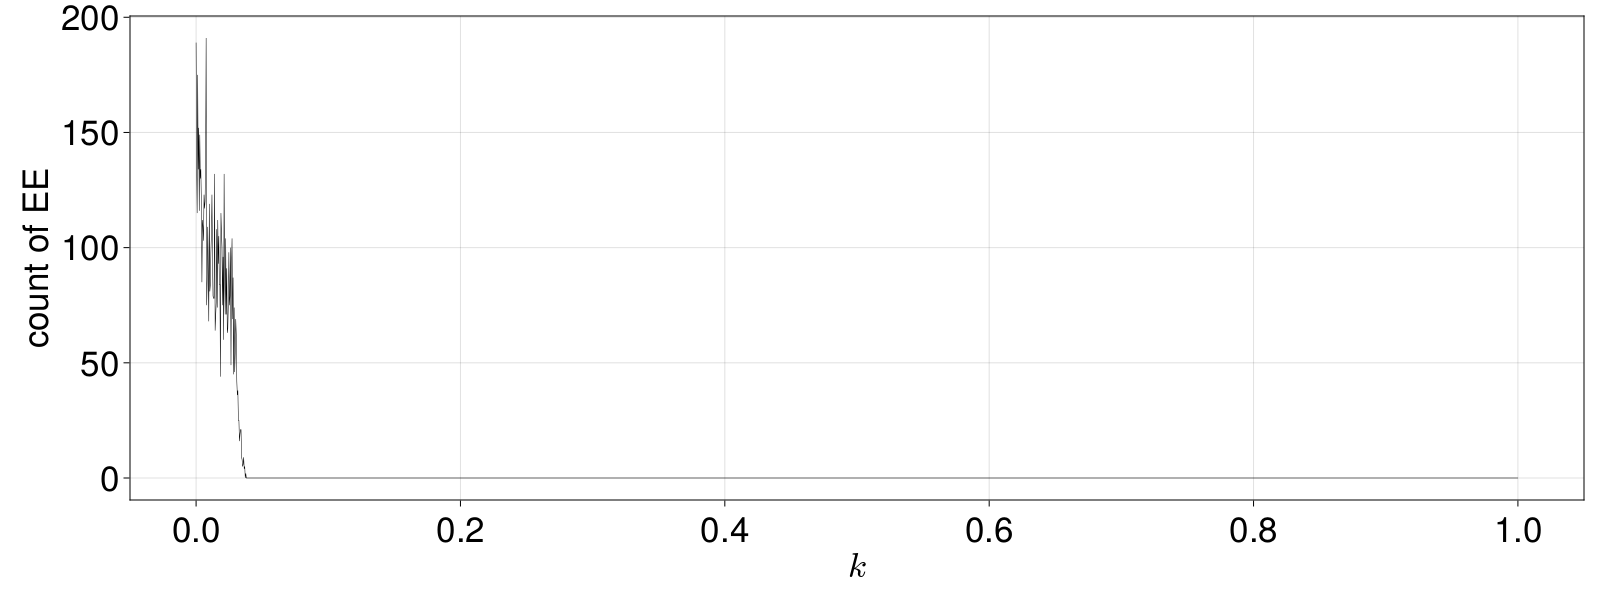

In [45]:
f = Figure(resolution = (1600, 600), fontsize = 35)

ax = Axis(f[1, 1], xlabel = L"k", ylabel = "count of EE")


limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
ax1.xticks = limits

lines!(ax, k_space, EVA_array, color = "black", linewidth = 0.5)

f

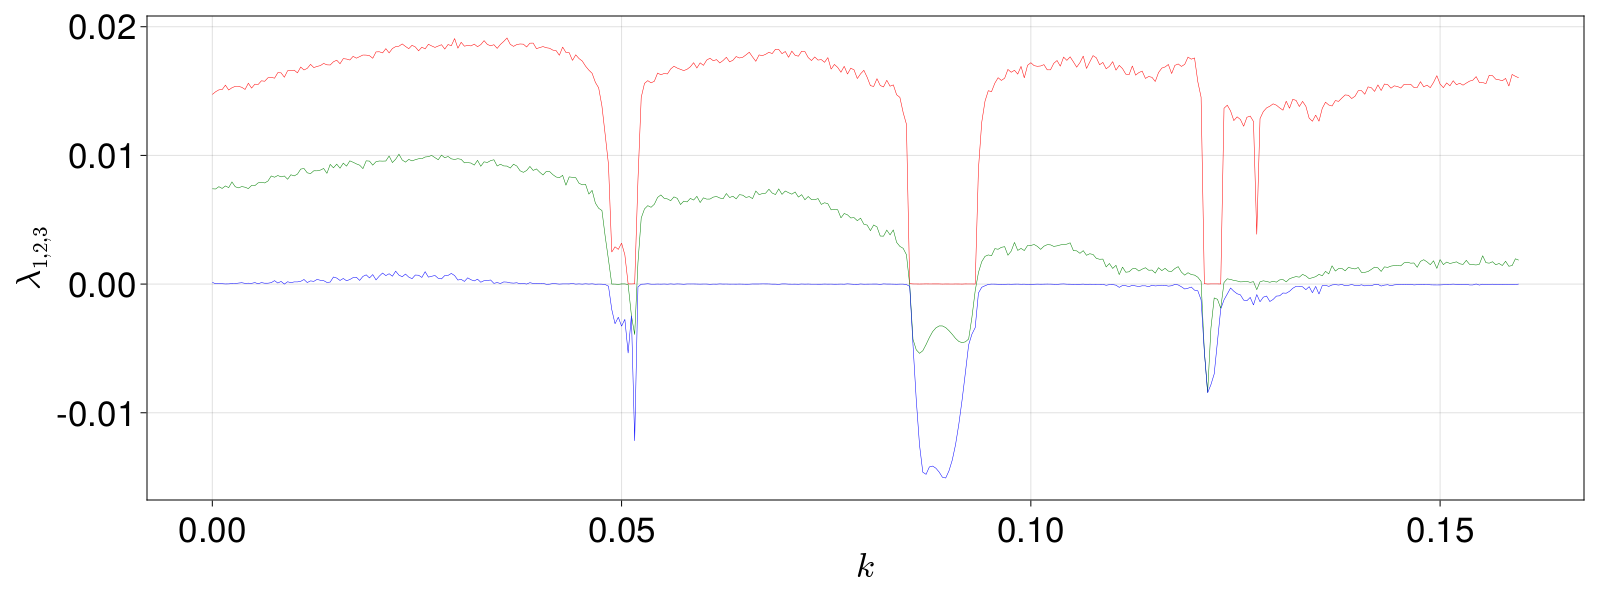

In [50]:
f = Figure(resolution = (1600, 600), fontsize = 35)

ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")

lines!(ax, k_space[1:400], spectrum_array[1, 1:400], color = "red", linewidth = 0.5)
lines!(ax, k_space[1:400], spectrum_array[2, 1:400], color = "green", linewidth = 0.5)
lines!(ax, k_space[1:400], spectrum_array[3, 1:400], color = "blue", linewidth = 0.5)

f